In [0]:
import numpy as np
from numpy.random import rand
from numpy.random import randint

from scipy.interpolate import Rbf
from scipy.interpolate import griddata

area_map_list = np.zeros((10000, 128, 128), dtype=np.float32)
point_map_list = np.zeros((10000, 128, 128), dtype=np.float32)
point_mask_map_list = np.zeros((10000, 128, 128), dtype=np.float32)

In [0]:
def gen_area_map():
    #Creating some data, with each coordinate and the values stored in separated lists
   
    x = []
    y = []

    x_it = randint(0,128)
    y_it = randint(0,128)
    
    for i in range(8):
        while x_it in x:
            x_it = randint(0,128)
        x.append(x_it)

        while y_it in y:
            y_it = randint(0,128)
        y.append(y_it)

    values = rand(8)

    #Creating the output grid (100x100, in the example)
    ti = np.linspace(0, 128.0, 128)
    XI, YI = np.meshgrid(ti, ti)

    #Creating the interpolation function and populating the output matrix value
    rbf = Rbf(x, y, values, function='inverse')
    area_map = rbf(XI, YI)

    return area_map.astype('float32')

In [0]:
def gen_point_map(area_map):
    point_x = [104,  14,  78,  5, 105,  56,  57,  96,  21, 112]
    point_y = [ 66,  16,  60,  15,  14, 114,  65,  76,  75,  100]

    point_map = np.zeros((128, 128), dtype=np.float32)
    point_mask_map = np.zeros((128, 128), dtype=np.float32)

    for i in range(0, 10):
      point_map[point_y[i], point_x[i]] = area_map[point_y[i], point_x[i]]
      point_mask_map[point_y[i], point_x[i]] = 1.0
    
    return point_map, point_mask_map

In [0]:
for i in range(10000):
    area_map = gen_area_map()
    point_map, point_mask_map = gen_point_map(area_map)
    area_map_list[i] = area_map
    point_map_list[i] = point_map
    point_mask_map_list[i] = point_mask_map

In [0]:
f = open('area_map_list.bin', 'wb')
f.write(area_map_list.tobytes())
f.close()

f = open('point_map_list.bin', 'wb')
f.write(point_map_list.tobytes())
f.close()

f = open('point_mask_map_list.bin', 'wb')
f.write(point_mask_map_list.tobytes())
f.close()

In [0]:
!ls

area_map_list.bin  point_map_list.bin  point_mask_map_list.bin	sample_data


In [0]:
import os

test_case_name = 'interp_no_mask_L1_no_J4'

if not os.path.isdir(test_case_name):
    os.mkdir(test_case_name)    

In [0]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk

In [0]:
import keras.backend as K

K.set_image_data_format('channels_last')

channel_axis = -1

Using TensorFlow backend.


In [0]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [0]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization

In [0]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)

def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, nc_out, ndf, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    input_a, input_b = Input(shape=(None, None, nc_in)), Input(shape=(None, None, nc_out))
    
    _ = Concatenate(axis=channel_axis)([input_a, input_b])
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_)

In [0]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    
    _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [0]:
nc_in = 1
nc_out = 1
ngf = 64
ndf = 64
lamda = 10

loadSize = 128
imageSize = 128

lrD = 2e-4
lrG = 2e-4

In [0]:
netD = BASIC_D(nc_in, nc_out, ndf)
netD.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 2 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
First (Conv2D)                  (None

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

netG = UNET_G(imageSize, nc_in, nc_out, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netG.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv_128 (Conv2D)               (None, 64, 64, 64)   1088        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 64, 64, 64)   0           conv_128[0][0]                   
__________________________________________________________________________________________________
conv_64 (Conv2D)                (None, 32, 32, 128)  131072      leaky_re_lu_5[0][0]         

In [0]:
from keras.optimizers import RMSprop, SGD, Adam

In [0]:
real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])
real_B = netD.inputs[1]
output_D_real = netD([real_A, real_B])
output_D_fake = netD([real_A, fake_B])

In [0]:
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))

loss_L1 = K.mean(K.abs(fake_B-real_B))
loss_L2 = K.sqrt(K.mean(K.square(fake_B-real_B)))

In [0]:
loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_D/2.0], training_updates)

In [0]:
# Loss L1
loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)

In [0]:
import numpy as np

area_map_list = np.fromfile('area_map_list.bin', dtype=np.float32)
point_map_list = np.fromfile('point_map_list.bin', dtype=np.float32)
point_mask_map_list = np.fromfile('point_mask_map_list.bin', dtype=np.float32)

In [0]:
area_map_list = area_map_list.reshape(10000, 128, 128, 1)
point_map_list = point_map_list.reshape(10000, 128, 128, 1)
point_mask_map_list = point_mask_map_list.reshape(10000, 128, 128, 1)

In [0]:
a_train = point_map_list[:6000]
b_train = area_map_list[:6000]
a_val = point_map_list[6000:8000]
b_val = area_map_list[6000:8000]
a_test = point_map_list[8000:]
b_test = area_map_list[8000:]

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

def show_map(a_map, b_map, c_map, count):
    
    for i in range(count):
        maps = np.concatenate([a_map[i], b_map[i], c_map[i]], axis=1)
        im = Image.fromarray(np.uint8(cm.viridis(maps)*255), mode='RGBA')
        display(im)

In [0]:
def save_maps(dir_path, a_map, b_map, c_map, count = -1):

    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)  
        
    if count == -1:
        count = a_map.shape[0]
    
    for i in range(count):
        maps = np.concatenate([a_map[i], b_map[i], c_map[i]], axis=1)
        im = Image.fromarray(np.uint8(cm.viridis(maps)*255), mode='RGBA')
        file_path = dir_path + str(i) + '.png'
        im.save(file_path, quality=90)
        print(file_path + ' is saved.')

In [0]:
def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

In [0]:
import time
from IPython.display import clear_output
from random import shuffle

t0 = time.time()
niter = 4
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 10

batch_start_idx = 0
batch_size = 16

[0/4][100] Loss_D: 0.612103 Loss_G: 0.920708 loss_L1: 0.116531 1432.254836320877


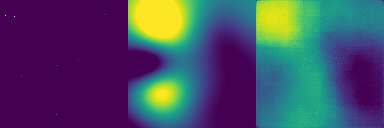

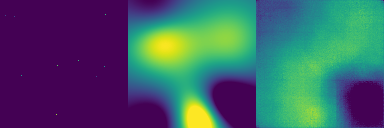

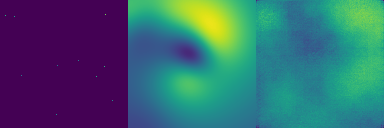

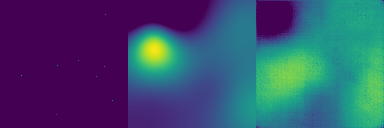

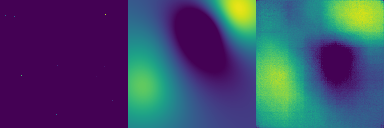

interp_no_mask_L1_no_J4/val_result_00100/0.png is saved.
interp_no_mask_L1_no_J4/val_result_00100/1.png is saved.
interp_no_mask_L1_no_J4/val_result_00100/2.png is saved.
interp_no_mask_L1_no_J4/val_result_00100/3.png is saved.
interp_no_mask_L1_no_J4/val_result_00100/4.png is saved.
[0/4][110] Loss_D: 0.693482 Loss_G: 1.035058 loss_L1: 0.133132 1576.5319924354553


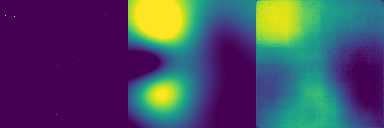

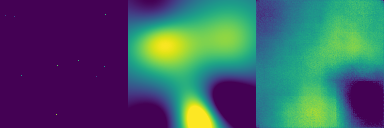

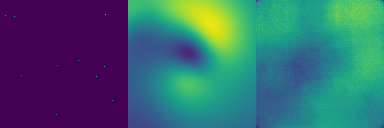

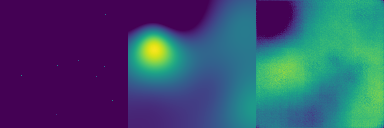

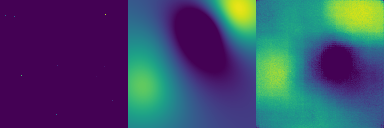

interp_no_mask_L1_no_J4/val_result_00110/0.png is saved.
interp_no_mask_L1_no_J4/val_result_00110/1.png is saved.
interp_no_mask_L1_no_J4/val_result_00110/2.png is saved.
interp_no_mask_L1_no_J4/val_result_00110/3.png is saved.
interp_no_mask_L1_no_J4/val_result_00110/4.png is saved.
[0/4][120] Loss_D: 0.479818 Loss_G: 1.318303 loss_L1: 0.135418 1725.4839434623718


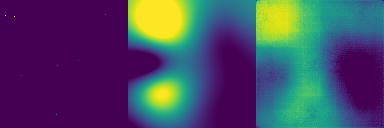

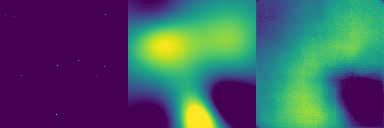

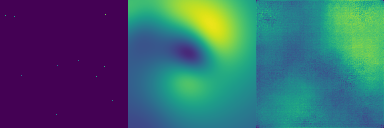

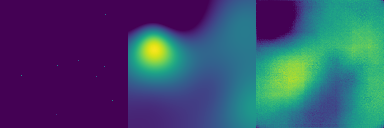

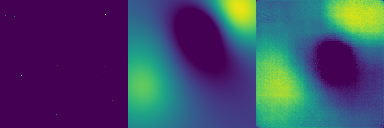

interp_no_mask_L1_no_J4/val_result_00120/0.png is saved.
interp_no_mask_L1_no_J4/val_result_00120/1.png is saved.
interp_no_mask_L1_no_J4/val_result_00120/2.png is saved.
interp_no_mask_L1_no_J4/val_result_00120/3.png is saved.
interp_no_mask_L1_no_J4/val_result_00120/4.png is saved.


In [0]:
while epoch < niter: 
    
    trainA = a_train[batch_start_idx:batch_start_idx+batch_size]
    trainB = b_train[batch_start_idx:batch_start_idx+batch_size]
    
    errD,  = netD_train([trainA, trainB])
    errD_sum +=errD

    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations += 1
    
    batch_start_idx += batch_size
    
    if batch_start_idx + batch_size > a_train.shape[0]:
        batch_start_idx = 0
        epoch += 1
        shuffle(a_train)
        shuffle(b_train)        
    
    if gen_iterations % display_iters == 0:

        if gen_iterations%(5*display_iters)==0:
            clear_output()

        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'% (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        
        errL1_sum = errG_sum = errD_sum = 0
        
        valA = a_val[0:5]
        valB = b_val[0:5]
        fakeB = netG_gen(valA)
        show_map(valA, valB, fakeB, 5)
        
        val_dir_path = test_case_name + '/val_result_%05d/' % gen_iterations

        save_maps(val_dir_path, valA, valB, fakeB, 5)

In [0]:
test_dir_path = test_case_name + '/test_result/'

b_hat_test = netG_gen(a_test)

save_images(test_dir_path, a_test, b_test, b_hat_test)

In [0]:
import imageio
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

for j in range(5):
    images = []

    for i in range(1400):
        if i % 10 == 0 and i != 0:
                filename = test_case_name + '/val_result_%05d/%d.png' % (i, j)
                
                img = Image.open(filename)
                
                draw = ImageDraw.Draw(img)
                font = ImageFont.truetype("sans-serif.ttf", 16)
                draw.text((10, 10),"iter %05d" %(i),(255,255,255),font=font)
                images.append(img)
    
    imageio.mimsave(test_case_name + '/val_iter_%d.gif'% (j), images, duration=0.1)